# [DATA SCIENTIST] Predicting Citibike Trips Using Snowflake & Facebook Prophet 

## 6.1 Preparation


### 6.1.1 Libraries to be installed

Make sure to install the following dependencies. Use conda_mxnet_p36 kernel 

<div class="alert alert-info"><h4>Note</h4><p>Only run the cell below the first time you run this notebook in SageMaker</p></div>


To install the depedencies, select the cell below, change its type to 'code' from the menu above and then run it.

In [ ]:
!pip install --upgrade pip && pip install --upgrade numpy
!pip install --upgrade snowflake-connector-python[pandas]
!conda install -c conda-forge matplotlib --yes
!conda install -c plotly plotly==3.10.0 --yes
!conda install -c conda-forge fbprophet --yes
!pip install --upgrade pystan
!pip install --upgrade fbprophet

***IMPORTANT: Make sure to restart the kernel before you move forward***

### 6.1.2 Prepare Connection


If you modified the password set the correct one here

In [3]:
import json

with open('creds.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

We first create a connection to our Snowflake account by specifying the auth details as well as the DB, schema and warehouse we want to use.

**Note**: Please change the `SF_ACCOUNT` and `SF_WH` variables below to your account & warehouse.
SF_ACCOUNT name is in your browser in the form of xxxx.snowflakecomputing.com. Remove snowflakecomputing.com and just get the account name.

The Wareshouse shoudl be SAGEMAKER_WH which is the one we previously created to isolate Data Scientist work from other users.

Import the libraries and connect to the database.

In [4]:
import snowflake.connector

In [5]:
import pandas as pd

#### The Snowflake connector takes about 2m15sec to fail... :(

In [6]:
SF_ACCOUNT = '<snowflake_acccount>'
SF_WH = 'SAGEMAKER_WH'

# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user=username,
  password=password,
  account=SF_ACCOUNT,
  warehouse=SF_WH,
  role='SAGEMAKER_ROLE',
  database='CITIBIKE',
  schema='public'
)

cur = ctx.cursor()

In [7]:
ctx.connect

<bound method SnowflakeConnection.connect of <snowflake.connector.connection.SnowflakeConnection object at 0x0000024C005811F0>>

## 6.2 Forecast number of trips per day
### 6.2.1 Basic model

Lets get the data for the number of trips per day and inspect the first five days

In [10]:
# Lets aggregate the trips data up to the day level
sql = "select date_trunc('day', STARTTIME) AS ds, count(*) AS y from trips" +\
        " group by date_trunc('day', STARTTIME)" +\
        " order by date_trunc('day', STARTTIME)"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()

In [14]:
df.head()

DS      Y
0 2013-06-01   8722
1 2013-06-02  15971
2 2013-06-03   7598
3 2013-06-04  15782
4 2013-06-05  15690

In [15]:
# export and re-import the SF output, just for safekeeping...
df.to_csv('bike_trips_per_day.csv')
df = pd.read_csv('bike_trips_per_day.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

DS      Y
0 2013-06-01   8722
1 2013-06-02  15971
2 2013-06-03   7598
3 2013-06-04  15782
4 2013-06-05  15690

Using Prophet let´s train our first model

In [16]:
from fbprophet import Prophet

In [20]:
# The FB Prophet library expects the data to be in two columns *exactly* with these names:
# 'ds' for timestamp and 'y' for the value
df.columns = ['ds','y']
df.head()

ds      y
0 2013-06-01   8722
1 2013-06-02  15971
2 2013-06-03   7598
3 2013-06-04  15782
4 2013-06-05  15690

In [21]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
print(model.__doc__)

Prophet forecaster.

    Parameters
    ----------
    growth: String 'linear' or 'logistic' to specify a linear or logistic
        trend.
    changepoints: List of dates at which to include potential changepoints. If
        not specified, potential changepoints are selected automatically.
    n_changepoints: Number of potential changepoints to include. Not used
        if input `changepoints` is supplied. If `changepoints` is not supplied,
        then n_changepoints potential changepoints are selected uniformly from
        the first `changepoint_range` proportion of the history.
    changepoint_range: Proportion of history in which trend changepoints will
        be estimated. Defaults to 0.8 for the first 80%. Not used if
        `changepoints` is specified.
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of 

Now let´s validate the precission of the model we have built

In [23]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [24]:
cutoffs = pd.to_datetime(['2018-01-01'])
df_cv = cross_validation(model, cutoffs=cutoffs, horizon = '180 days')

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

horizon           mse         rmse          mae      mape     mdape  \
0 180 days  1.583755e+08  12584.73241  10157.47514  0.554698  0.188597   

   coverage  
0  0.566667

We are going to take a look to the RMSE (root-mean-square deviation) as the metric to measure how well the model is performing. We are having 12584 and we are going to see if that can be improved.

First let´s use this model to get some graphical representation of a future prediction:

In [29]:
# 2-yr future prediction (730 periods)
future = model.make_future_dataframe(periods=730)
forecast = model.predict(future)

In [75]:
future.tail()

ds
2573 2020-06-25
2574 2020-06-26
2575 2020-06-27
2576 2020-06-28
2577 2020-06-29

In [30]:
forecast.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
2573 2020-06-25  61188.901464  61415.381678  85798.895141  55360.637383   
2574 2020-06-26  61204.185396  59105.800186  83984.850516  55362.544245   
2575 2020-06-27  61219.469329  53031.634861  78139.512757  55364.814666   
2576 2020-06-28  61234.753261  51048.362288  75472.411733  55365.173137   
2577 2020-06-29  61250.037194  58087.353878  83559.656167  55365.531608   

       trend_upper  additive_terms  additive_terms_lower  \
2573  67177.933964    12156.855548          12156.855548   
2574  67210.367886    10326.798104          10326.798104   
2575  67240.328997     4217.482735           4217.482735   
2576  67262.892277     2607.511465           2607.511465   
2577  67283.339194     8794.474755           8794.474755   

      additive_terms_upper       weekly  weekly_lower  weekly_upper  \
2573          12156.855548  2936.085911   2936.085911   2936.085911   
2574          10326.798104  1280.135132   1280.135132   1280.135132   
2575           4217.482735 -4643.606748  -4643.606748  -4643.606748   
2576           2607.511465 -6061.561884  -6061.561884  -6061.561884   
2577           8794.474755   318.744880    318.744880    318.744880   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
2573  9220.769638   9220.769638   9220.769638                   0.0   
2574  9046.662972   9046.662972   9046.662972                   0.0   
2575  8861.089483   8861.089483   8861.089483                   0.0   
2576  8669.073349   8669.073349   8669.073349                   0.0   
2577  8475.729875   8475.729875   8475.729875                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
2573                         0.0                         0.0  73345.757012  
2574                         0.0                         0.0  71530.983500  
2575                         0.0                         0.0  65436.952063  
2576                         0.0                         0.0  63842.264726  
2577                         0.0                         0.0  70044.511948

In [31]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
2573 2020-06-25  73345.757012  61415.381678  85798.895141
2574 2020-06-26  71530.983500  59105.800186  83984.850516
2575 2020-06-27  65436.952063  53031.634861  78139.512757
2576 2020-06-28  63842.264726  51048.362288  75472.411733
2577 2020-06-29  70044.511948  58087.353878  83559.656167

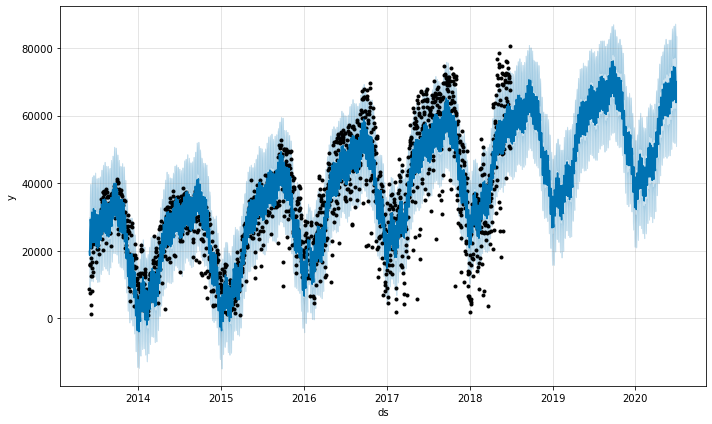

In [34]:
fig1 = model.plot(forecast)

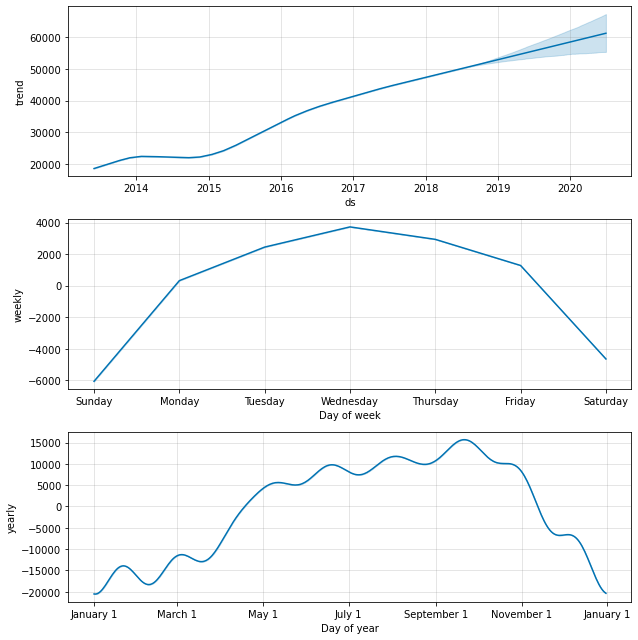

In [35]:
fig2 = model.plot_components(forecast)

#### Interactive charts using plotly

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

In [36]:
plot_plotly(model, forecast)

In [37]:
plot_components_plotly(model, forecast)

### 6.2.2 Enhancing Model Accuracy by Enriching Data

Let's see how we can make our model even better by enriching our data from Snowflake Data Marketplace. Our data scientists and analysts think that a `feature` on weather temperature will yield a better model. 

#### 👉🏼 Enrich datasets using Snowflake Data Marketplace & Data Sharing => Better, more accurate models

Let us quickly bring in weather data from Snowflake Data Marketplace, join it with the trips data. In our weather data, we have a column named `MAX_TEMPERATURE_FEELSLIKE_2M_F` which give the temperature for the day. Using Snowflake SQL, we can quickly use the built-in SQL to feature engineer a temperature feature called `t`.  

In [40]:
sql = "select date_trunc('day', STARTTIME) d, avg(w.AVG_TEMPERATURE_FEELSLIKE_2M_F), count(*) " +\
        "from trips t, WEATHER.PUBLIC.HISTORY_DAY w " +\
        "where d = w.DATE_VALID_STD and w.POSTAL_CODE = '06101' " +\
        "group by 1 " +\
        "order by 1;"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()

INFO:snowflake.connector.cursor:query: [select date_trunc('day', STARTTIME) d, avg(w.AVG_TEMPERATURE_FEELSLIKE_2M_F), co...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data into pandas dataframe done


In [41]:
df.head()

D AVG(W.AVG_TEMPERATURE_FEELSLIKE_2M_F)  COUNT(*)
0 2013-06-01                            81.1000000      8722
1 2013-06-02                            77.4000000     15971
2 2013-06-03                            70.5000000      7598
3 2013-06-04                            62.7000000     15782
4 2013-06-05                            63.9000000     15690

In [42]:
df.columns = ['ds', 't', 'y']
df.tail()

ds           t      y
1843 2018-06-26  66.2000000  80646
1844 2018-06-27  68.1000000  67698
1845 2018-06-28  74.2000000  50432
1846 2018-06-29  78.5000000  69859
1847 2018-06-30  81.4000000  54721

In [43]:
enhanced_model = Prophet()
enhanced_model.add_regressor('t')
enhanced_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Let´s validate the model (note this one will take a few seconds):

In [44]:
cutoffs = pd.to_datetime(['2018-01-01'])
df_cv = cross_validation(enhanced_model, cutoffs=cutoffs, horizon = '180 days')

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

horizon           mse          rmse          mae      mape    mdape  \
0 180 days  1.492600e+08  12217.202655  9816.821717  0.522418  0.18456   

   coverage  
0       1.0

With the new weather feature we have improved the RMSE and it is now 12217

## 6.3 Predicting Usage at the Busiest Stations
### 6.3.1 Basic Model
The business wants to better predict how many bikes should be placed at the busiest stations. 

#### 👉🏼 Powerful and quick analysis using ANSI SQL => Data Scientist Productivity

In [49]:
sql = "select start_station_name, count(*) trips  " +\
        "from trips " +\
        "group by start_station_name " +\
        "order by trips desc limit 5;"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df_top_stations = cur.fetch_pandas_all()

INFO:snowflake.connector.cursor:query: [select start_station_name, count(*) trips  from trips group by start_station_nam...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data into pandas dataframe done


In [50]:
df_top_stations.tail()

START_STATION_NAME   TRIPS
0  Pershing Square North  491951
1     E 17 St & Broadway  481065
2        W 21 St & 6 Ave  458626
3        8 Ave & W 31 St  438001
4  West St & Chambers St  432518

#### Train a model specifically for one station

In [51]:
sql = "select start_station_name, date_trunc('day', STARTTIME) d, count(*) " +\
        "from CITIBIKE.public.trips " +\
        "where start_station_name like 'E 17 St & Broadway' " +\
        "group by 1, 2 " +\
        "order by 2"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()
df.columns=['station', 'ds', 'y']
df.tail()

INFO:snowflake.connector.cursor:query: [select start_station_name, date_trunc('day', STARTTIME) d, count(*) from CITIBIK...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data into pandas dataframe done


station         ds    y
1841  E 17 St & Broadway 2018-06-26  478
1842  E 17 St & Broadway 2018-06-27  307
1843  E 17 St & Broadway 2018-06-28  299
1844  E 17 St & Broadway 2018-06-29  436
1845  E 17 St & Broadway 2018-06-30  300

In [52]:
station_model = Prophet(daily_seasonality=True)
station_model.add_country_holidays('US')
station_model.fit(df)

#### Now we evaluate the model by measuring the Root Mean Squared Error (RMSE).

In [53]:
cutoffs = pd.to_datetime(['2018-01-01'])
df_cv = cross_validation(station_model, cutoffs=cutoffs, horizon = '180 days')

  0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

horizon          mse       rmse        mae      mape     mdape  coverage
0 180 days  6425.614913  80.159933  58.610378  0.775238  0.152749  0.805556

### 6.3.2 Enhancing the model accuracy by enriching data
#### Now enhance the model by using average temperature during the day.

In [78]:
sql = "select start_station_name, date_trunc('day', STARTTIME) d, avg(w.AVG_TEMPERATURE_FEELSLIKE_2M_F), count(*) " +\
        "from trips t, WEATHER.PUBLIC.HISTORY_DAY w " +\
        "where start_station_name like 'E 17 St & Broadway' " +\
        "and d = w.DATE_VALID_STD and w.POSTAL_CODE = '06101' " +\
        "group by 1, 2 " +\
        "order by 2;"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cur.fetch_pandas_all()
df.columns = ['station', 'ds', 't', 'y']
df.tail()

INFO:snowflake.connector.cursor:query: [select start_station_name, date_trunc('day', STARTTIME) d, avg(w.AVG_TEMPERATURE...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data into pandas dataframe done


station         ds           t    y
1841  E 17 St & Broadway 2018-06-26  66.2000000  478
1842  E 17 St & Broadway 2018-06-27  68.1000000  307
1843  E 17 St & Broadway 2018-06-28  74.2000000  299
1844  E 17 St & Broadway 2018-06-29  78.5000000  436
1845  E 17 St & Broadway 2018-06-30  81.4000000  300

#### Train the enhanced model specifically for this station

In [79]:
enhanced_station_model = Prophet(daily_seasonality=True)
enhanced_station_model.add_country_holidays('US')

# add a regressor for the temperature feature
enhanced_station_model.add_regressor('t')

enhanced_station_model.fit(df)

#### Now we evaluate the model by measuring the Root Mean Squared Error (RMSE).

In [80]:
cutoffs = pd.to_datetime(['2018-01-01'])
df_cv = cross_validation(enhanced_station_model, cutoffs=cutoffs, horizon = '180 days')

  0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

horizon          mse       rmse        mae      mape     mdape  coverage
0 180 days  5875.055767  76.648912  58.099117  0.727515  0.155661       1.0

Notice that we were able to enhance the RMSE 👆🏼 by quickly enriching our data from the Snowflake Data Marketplace and performing feature engineering in simple and scalable ANSI SQL.

### 6.3.3 Predict next days for one station

We want to predict the bike usage for the `E 17 St & Broadway` station for the next 14 days. For this, we need to create a dataframe that includes the temperature forecast for the next 14 days.

In [82]:
last_day = str(df['ds'].iloc[-1])
last_day

'2018-06-30 00:00:00'

In [83]:
sql = "select DATE_VALID_STD ds, AVG_TEMPERATURE_FEELSLIKE_2M_F t " +\
        "from WEATHER.public.HISTORY_DAY " +\
        "where POSTAL_CODE like '06101' " +\
        "and DATE_VALID_STD <  dateadd(day, 15, to_date('" + last_day + "')) " +\
        "order by DATE_VALID_STD;"
cur.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df_future = cur.fetch_pandas_all()
df_future.columns = ['ds', 't']

INFO:snowflake.connector.cursor:query: [select DATE_VALID_STD ds, AVG_TEMPERATURE_FEELSLIKE_2M_F t from WEATHER.public.H...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.arrow_result:fetching data into pandas dataframe done


In [84]:
df_future.head()

ds     t
0  2013-01-01  24.5
1  2013-01-02  15.5
2  2013-01-03  15.8
3  2013-01-04  25.1
4  2013-01-05  28.9

In [85]:
df_future.tail()

ds     t
2016  2018-07-10  80.3
2017  2018-07-11  75.8
2018  2018-07-12  72.7
2019  2018-07-13  75.5
2020  2018-07-14  76.1

Now we make the predictions for all time and the next 14 days.

In [105]:
forecast = enhanced_station_model.predict(df_future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2016 2018-07-10  394.419577  302.955597  487.701849
2017 2018-07-11  421.242845  338.616224  508.614465
2018 2018-07-12  400.281332  307.764352  483.383473
2019 2018-07-13  399.832170  308.364163  485.724714
2020 2018-07-14  382.256608  295.323756  470.282007

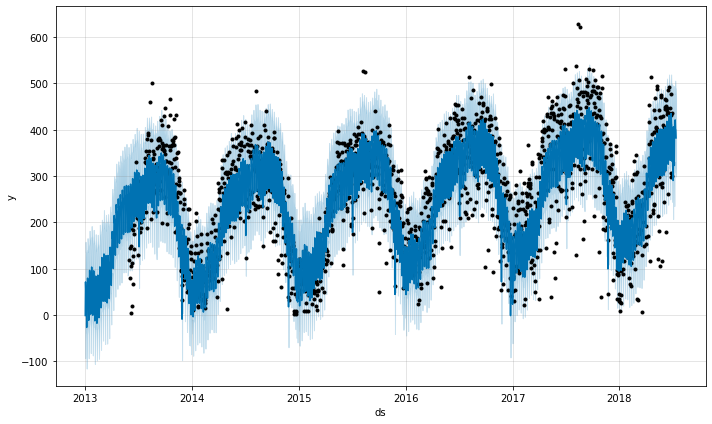

In [87]:
fig2 = enhanced_station_model.plot(forecast)

Let's zoom in and look at the last 100 days

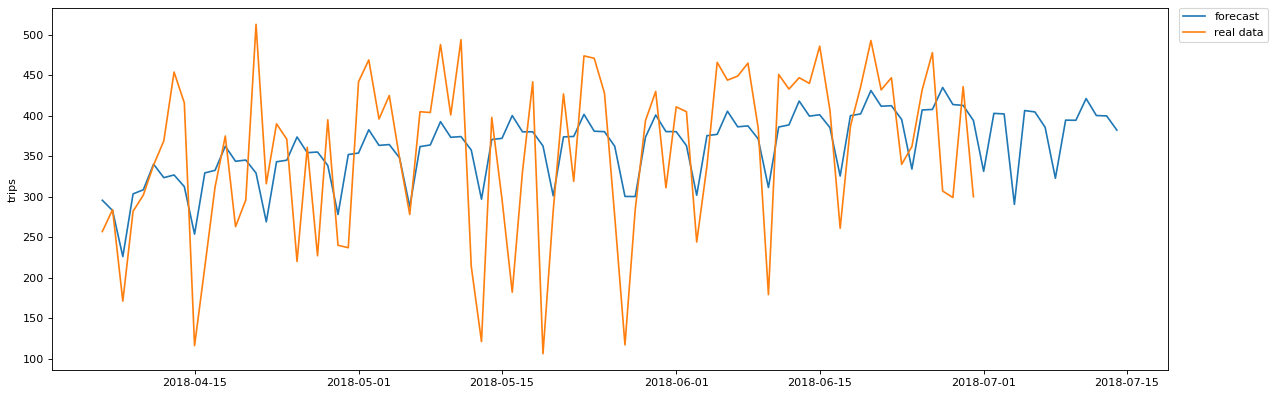

In [102]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

recent_forecast = forecast.tail(100)

figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(recent_forecast['ds'], recent_forecast['yhat'], label='forecast')
plt.plot(df.tail(86)['ds'], df.tail(86)['y'], label='real data')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.ylabel('trips')

plt.show()

### 6.3.4 Write the predictions back into Snowflake

First, lets get all the attributes that we want to store back into Snowflake.

In [106]:
forecast = forecast[['ds', 'yhat']]
forecast.columns = ['DS', 'YHAT']
forecast['START_STATION_NAME'] = 'E 17 St & Broadway'

In [107]:
forecast.head()

DS       YHAT  START_STATION_NAME
0 2013-01-01  -0.891421  E 17 St & Broadway
1 2013-01-02  71.526678  E 17 St & Broadway
2 2013-01-03  50.853941  E 17 St & Broadway
3 2013-01-04  50.881438  E 17 St & Broadway
4 2013-01-05  33.927376  E 17 St & Broadway

In [108]:
forecast.tail()

DS        YHAT  START_STATION_NAME
2016 2018-07-10  394.419577  E 17 St & Broadway
2017 2018-07-11  421.242845  E 17 St & Broadway
2018 2018-07-12  400.281332  E 17 St & Broadway
2019 2018-07-13  399.832170  E 17 St & Broadway
2020 2018-07-14  382.256608  E 17 St & Broadway

In [109]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DS                  2021 non-null   datetime64[ns]
 1   YHAT                2021 non-null   float64       
 2   START_STATION_NAME  2021 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.5+ KB


In [110]:
dfstr = forecast
dfstr.head()

DS       YHAT  START_STATION_NAME
0 2013-01-01  -0.891421  E 17 St & Broadway
1 2013-01-02  71.526678  E 17 St & Broadway
2 2013-01-03  50.853941  E 17 St & Broadway
3 2013-01-04  50.881438  E 17 St & Broadway
4 2013-01-05  33.927376  E 17 St & Broadway

In [111]:
dfstr['DS'] = dfstr['DS'].dt.strftime('%Y-%m-%d')

In [112]:
dfstr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DS                  2021 non-null   object 
 1   YHAT                2021 non-null   float64
 2   START_STATION_NAME  2021 non-null   object 
dtypes: float64(1), object(2)
memory usage: 47.5+ KB


In [113]:
dfstr.head()

DS       YHAT  START_STATION_NAME
0  2013-01-01  -0.891421  E 17 St & Broadway
1  2013-01-02  71.526678  E 17 St & Broadway
2  2013-01-03  50.853941  E 17 St & Broadway
3  2013-01-04  50.881438  E 17 St & Broadway
4  2013-01-05  33.927376  E 17 St & Broadway

In [116]:
forecast.to_csv('forecast.csv')

In [114]:
# Dump forecast dataframe to Snowflake table

from snowflake.connector.pandas_tools import write_pandas

# success, nchunks, nrows, _ = write_pandas(ctx, forecast, 'TRIPS_FORECAST')
success, nchunks, nrows, _ = write_pandas(ctx, dfstr, 'TRIPS_FORECAST')

INFO:snowflake.connector.cursor:query: [create temporary stage /* Python:snowflake.connector.pandas_tools.write_pandas()...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.json_result:fetching data done
INFO:snowflake.connector.cursor:query: [PUT /* Python:snowflake.connector.pandas_tools.write_pandas() */ 'file://C:\\Use...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [COPY INTO "TRIPS_FORECAST" /* Python:snowflake.connector.pandas_tools.write_pand...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.json_result:fetching data done


In [115]:
ctx.close()

INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.connection:No async queries seem to be running, deleting session
